In [1]:
## running once
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from toolz.curried import *
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset

In [3]:
from util import *

In [4]:
year, month = 2021, 4
carpark_dir = "/home/xiucheng/data/carparking"
month_dir = os.path.join(carpark_dir, f"{year}/{month:02}")
carpark_meta = load_carpark_meta(os.path.join(carpark_dir, "carpark_meta.geojson"))

In [5]:
#carpark_meta

#carpark_meta[carpark_meta.Agency == "HDB"]

#carpark_meta[carpark_meta.Agency == "URA"]

#carpark_meta[carpark_meta.Agency == "LTA"].head()

In [6]:
%%time
carpark_data_names = [
    "carpark_data_2021_04_16-20.json",
    #"carpark_data_2021_04_21-25.json",
    #"carpark_data_2021_04_26-30.json"
]

carpark_data = load_carpark_data_list(
    [os.path.join(carpark_dir, name) for name in carpark_data_names]
)

Loading /home/xiucheng/data/carparking/carpark_data_2021_04_16-20.json
CPU times: user 2min 4s, sys: 8.1 s, total: 2min 12s
Wall time: 2min 13s


In [7]:
carpark_data_o = carpark_data.copy()
carpark_data_o.reset_index(inplace=True)
carpark_data_o.rename(columns={"tid": "date"}, inplace=True)

carpark_data = carpark_remove_outlier(carpark_data)
carpark_data = carpark_data.fillna(method="ffill")

100%|██████████| 1917/1917 [02:10<00:00, 14.64it/s]


In [8]:
carpark_data = carpark_add_date(carpark_data)
carpark_data = carpark_remove_constant(carpark_data)
carpark_data["min"] = (carpark_data.tid % 1440 // 5).astype(str)
len(carpark_data.sid.unique())

1800

In [9]:
#constant_sids = np.setdiff1d(carpark_meta.sid, carpark_data.sid.unique())
#carpark_meta[carpark_meta.sid.isin(constant_sids)]

## Visualization

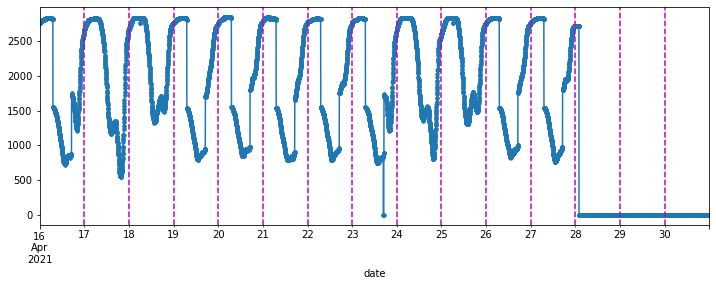

In [11]:
xs = pd.date_range("2021-04-17", periods=14)
ts = carpark_data[carpark_data.sid == 0].set_index("date")["AvailableLots"]
ts.plot(figsize=(12, 4), style=".-")
for x in xs:
    plt.axvline(x=x, linestyle='--', color="m")

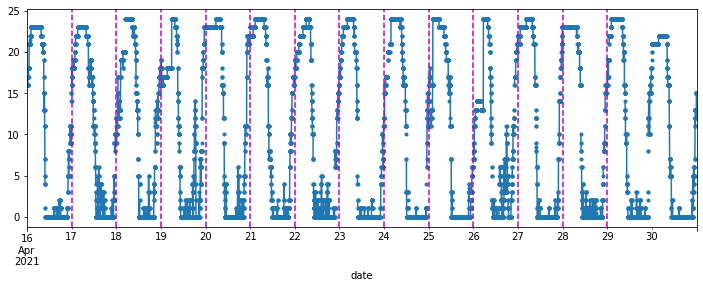

In [158]:
xs = pd.date_range("2021-04-17", periods=13)
ts = carpark_data_o[carpark_data_o.sid == 53].set_index("date")["AvailableLots"]
ts.plot(figsize=(12, 4), style=".-")
for x in xs:
    plt.axvline(x=x, linestyle='--', color="m")

In [22]:
# ts = carpark_data_o[carpark_data_o.sid == 45].set_index("date")["AvailableLots"]
# xs = ts[ts.diff().abs() > 100].index
# ts[sorted(np.concatenate([xs, xs - np.timedelta64(1, "m")]))]

# carpark_meta[carpark_meta.sid == 45]

## Forecasting

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE
from dataloader import subset_sampler

In [12]:
context_length = 10*60
prediction_length = 2*60

training_cutoff = 3*24*60
validation_cutoff = 4*24*60

training = TimeSeriesDataSet(
    carpark_data[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["min"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data,
    min_prediction_idx=validation_cutoff + 1
)

In [13]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)

In [14]:
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)                                                                       

In [15]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

32418
237
237


In [16]:
# x_trn, y_trn = first(train_dataloader)
# x_val, y_val = first(val_dataloader)
# x_tst, y_tst = first(test_dataloader)

# x_trn["encoder_cat"].shape

# x_trn["decoder_cont"].shape

# x_trn["decoder_target"]

# rnn.output_transformer(dict(prediction=x_trn["decoder_cont"],
#                             target_scale=x_trn["target_scale"])).squeeze()
# training.target_normalizer(dict(prediction=x_trn["decoder_cont"],
#                                 target_scale=x_trn["target_scale"])).squeeze()

In [17]:
#training.index

In [18]:
# from pytorch_forecasting import Baseline

# baseline_predictions = Baseline().predict(test_dataloader)

# abs_error = torch.abs(baseline_predictions - actuals)

# print(torch.mean(abs_error * mask))
# errors = torch.mean(abs_error * mask, dim=0)

# mape = abs_error / (actuals + 1e-5)

# print(torch.mean(mape * mask))
# mapes = torch.mean(mape * mask, dim=0)

# plt.plot(torch.arange(1, len(errors)+1), errors, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAE")

# plt.plot(torch.arange(1, len(mapes)+1), mapes, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAPE")

In [25]:
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0

### LSTM

In [19]:
from models import RNN

In [20]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=20,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [21]:
trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.2 K
3 | rnn              | GRU            | 9.4 K 
4 | output_projector | Linear         | 21    
----------------------------------------------------
35.6 K    Trainable params
0         Non-trainable params
35.6 K    Total params
0.142     Total estimated model params size (MB)


1

In [22]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)

/home/xiucheng/Github/carpark/lightning_logs/version_0/checkpoints/epoch=5-step=2999.ckpt
cuda:0


In [23]:
%%time
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)

torch.Size([118500, 120])
CPU times: user 25.2 s, sys: 1.96 s, total: 27.1 s
Wall time: 28.1 s


In [26]:
abs_error = torch.abs(predictions - actuals)

In [27]:
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)

tensor(10.5074)


In [28]:
mape = abs_error / (actuals + 1e-5)

In [29]:
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)

tensor(0.1242)


Text(0, 0.5, 'MAE')

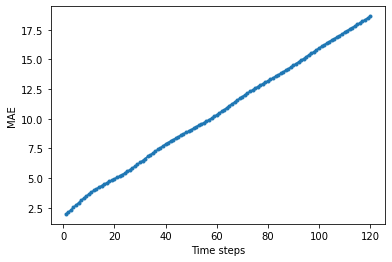

In [30]:
plt.plot(torch.arange(1, len(abs_error_steps)+1), abs_error_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

Text(0, 0.5, 'MAPE')

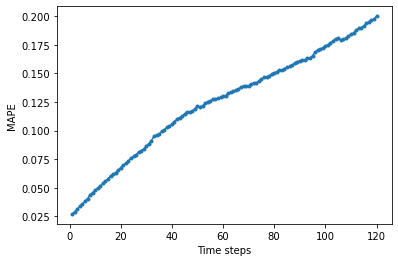

In [31]:
plt.plot(torch.arange(1, len(mape_steps)+1), mape_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAPE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [33]:
n = abs_error.shape[0]

In [34]:
step = 30 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()

μ = 6.3175, σ = 18.2701, max = 2492.1147


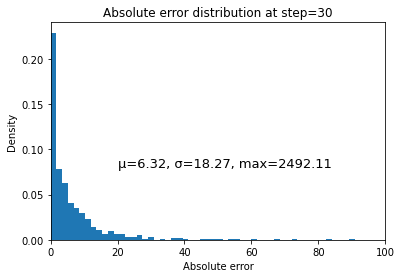

In [35]:
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

In [ ]:
# raw_predictions, x = best_model.predict(test_dataloader, mode="raw", return_x=True, 
#                                         fast_dev_run=True)

# for idx in range(5, 10):
#     best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);